# ML8. Neural Networks

## 0. Imports

In [1]:
!pip install -q category_encoders

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn as sk
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

### helper functions

In [3]:
def nan_clear(data:pd.DataFrame):
  max_size = 0.5 * len(data)
  col_to_del = []
  for col in data.columns:
    if data[col].isna().sum() >= max_size:
      col_to_del.append(col)
  data = data.drop(col_to_del, axis=1)

  cat_cols = data.select_dtypes(include='object').columns.tolist()
  num_cols = data.select_dtypes(include=['int64',"float64"]).columns.tolist()

  for cat in cat_cols:
    if data[cat].isna().sum() != 0:
      data[cat] = data[cat].fillna(data[cat].mode()[0])

  for num in num_cols:
    if data[num].isna().sum() != 0:
      data[num] = data[num].fillna(data[num].mean())
  return data

In [4]:
def preprocess_data(train_df:pd.DataFrame, valid_df:pd.DataFrame, test_df:pd.DataFrame):

  train_df = train_df.copy()
  valid_df = valid_df.copy()
  test_df = test_df.copy()

  vehodo_counts = train_df["VehOdo"].value_counts()
  train_df["VehOdo_encoded"] = train_df["VehOdo"].map(vehodo_counts)
  median = train_df["VehOdo_encoded"].median()
  train_df["VehOdo_encoded"] = train_df["VehOdo_encoded"].fillna(median) # NaN

  for df in [valid_df, test_df]:
    df["VehOdo_encoded"] = df["VehOdo"].map(vehodo_counts)
    df["VehOdo_encoded"] = df["VehOdo_encoded"].fillna(median)

  cols_to_drop = ["VehOdo", "RefId"]
  train_df = train_df.drop(columns=cols_to_drop)
  valid_df = valid_df.drop(columns=cols_to_drop)
  test_df = test_df.drop(columns=cols_to_drop)

  return train_df, valid_df, test_df

In [5]:
def tvt_split_by_time(train_df:pd.DataFrame):
  total = len(train_df)
  train_end_idx = int(total * 0.33)
  val_end_idx = int(total * 0.66)

  train_df["PurchDate"] = pd.to_datetime(train_df["PurchDate"], errors='coerce')
  train_df = train_df.sort_values(by="PurchDate")
  train_df["PurchDate"] = train_df["PurchDate"].astype(int)

  X = train_df.drop(["IsBadBuy"], axis=1)
  Y = train_df["IsBadBuy"]

  while X.loc[train_end_idx]["PurchDate"] == X.loc[val_end_idx]["PurchDate"]:
    val_end_idx +=1
    print(val_end_idx)

  X_train = X.iloc[:train_end_idx]
  X_valid = X.iloc[train_end_idx:val_end_idx]
  X_test = X.iloc[val_end_idx:]

  Y_train = Y.iloc[:train_end_idx]
  Y_valid = Y.iloc[train_end_idx:val_end_idx]
  Y_test = Y.iloc[val_end_idx:]
  return X_train, X_valid, X_test, Y_train, Y_valid, Y_test

In [6]:
def categories_transform(train_data:pd.DataFrame, X_train, X_valid, X_test):
  cat_cols = [col for col in train_data.select_dtypes(include='object').columns if col in X_train.columns]
  count_encoder = ce.CountEncoder(cols=cat_cols)
  train_encoded = count_encoder.fit_transform(X_train)
  valid_encoded = count_encoder.transform(X_valid)
  test_encoded = count_encoder.transform(X_test)
  return train_encoded, valid_encoded, test_encoded

In [7]:
gini_results_list = []
def calc_gini(y_true, y_pred):
  auc_score = roc_auc_score(y_true, y_pred)
  gini = 2 * auc_score - 1
  return gini

In [8]:
def gini_results(model, X_train, X_valid, X_test, Y_train, Y_valid, Y_test, model_descr:str):
  if ("Sk_MLP" in model_descr) or ("_v2" in model_descr):
    train_pred = model.predict_proba(X_train)[:, 1]
    valid_pred = model.predict_proba(X_valid)[:, 1]
    test_pred = model.predict_proba(X_test)[:, 1]
  else:
    train_pred = model.predict_proba(X_train)[:, 0]
    valid_pred = model.predict_proba(X_valid)[:, 0]
    test_pred = model.predict_proba(X_test)[:, 0]

  train_gini = calc_gini(Y_train, train_pred)
  valid_gini = calc_gini(Y_valid, valid_pred)
  test_gini = calc_gini(Y_test, test_pred)

  gini_results_list.append({
    'model': model_descr,
    'train_gini': f"{train_gini:.4f}",
    'valid_gini': f"{valid_gini:.4f}",
    'test_gini': f"{test_gini:.4f}"
})

In [9]:
def prepare_data_for_MLP():
  train_data = pd.read_csv("training.csv")
  train_data = nan_clear(train_data)

  X_train, X_valid, X_test, Y_train, Y_valid, Y_test = tvt_split_by_time(train_data)
  X_train, X_valid, X_test = preprocess_data(X_train, X_valid, X_test)
  X_train, X_valid, X_test  = categories_transform(train_data, X_train, X_valid, X_test)

  sk = StandardScaler()
  X_train = sk.fit_transform(X_train )
  X_valid = sk.transform(X_valid)
  X_test = sk.transform(X_test)
  return X_train, X_valid, X_test, Y_train, Y_valid, Y_test

In [10]:
def train_plot_loss_log(model, X_train, Y_train, X_valid, Y_valid, n_epochs=300):
    train_losses = []
    val_losses = []
    epochs = []

    for epoch in range(n_epochs):
        model.fit(X_train, Y_train)

        train_loss, _ = model.score(X_train, Y_train)
        val_loss,   _ = model.score(X_valid, Y_valid)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        epochs.append(epoch + 1)

        #if (epoch + 1) % 20 == 0 or epoch == 0:
            #print(f"Epoch {epoch+1:3d} | Train loss: {train_loss:.4e} | Val loss: {val_loss:.4e}")


    params = []
    if hasattr(model, 'activation'):
        params.append(f"activation={model.activation}")
    if hasattr(model, 'optimizer'):
        params.append(f"optimizer={model.optimizer}")
    param_str = ", ".join(params) if params else "MLP"


    plt.figure(figsize=(9, 6))
    plt.plot(epochs, train_losses, label='Train loss', color='blue', linewidth=2)
    plt.plot(epochs, val_losses, label='Validation loss', color='orange', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Binary Cross‑Entropy Loss')
    plt.title(f'Training ({param_str})')
    plt.yscale('linear')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    return model

## 1. Data preprocessing

- Design a train/validation/test split.

In [11]:
!gdown 1ogHQ9uWJ-1Xl9F2jDoWAGV3Q-no6IVCq

Downloading...
From: https://drive.google.com/uc?id=1ogHQ9uWJ-1Xl9F2jDoWAGV3Q-no6IVCq
To: /content/training.csv
100% 14.5M/14.5M [00:00<00:00, 34.1MB/s]


In [12]:
train_data = pd.read_csv("training.csv")
train_data = nan_clear(train_data)
#train_data.info()

In [13]:
train_data = nan_clear(train_data)
print(train_data.isna().sum().any()) # False - NaNов нет
#train_data.info()

False


- Use the "PurchDate" field for the split, test must be later in time than validation, same goes for validation and train: train.PurchDate < valid.PurchDate < test.PurchDate.
Use the first 33% of the dates for the train, the last 33% of the dates for the test, and the middle 33% for the validation set. Don't use the test dataset until the end!

In [14]:
X_train, X_valid, X_test, Y_train, Y_valid, Y_test = tvt_split_by_time(train_data)
len(X_train), len(X_valid), len(X_test)

(24084, 24084, 24815)

- Use sklearn's LabelEncoder or OneHotEncoder to preprocess categorical variables. Be careful with data leakage (fit Encoder to train and apply to validation & test). Consider another coding approach if you encounter new categorical values in validation & test (not seen in training).

In [15]:
X_train, X_valid, X_test = preprocess_data(X_train, X_valid, X_test)
X_train, X_valid, X_test  = categories_transform(train_data, X_train, X_valid, X_test)
X_train.sample(5)

,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,...,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost,VehOdo_encoded
19636,1245715200000000000,5171,2007,2,5612,229,999,5,4162,23416,...,0.0,0.0,0.0,21053,95673,2520,6935.0,0,1243,1
27663,1240358400000000000,13960,2005,4,5612,240,5193,4846,4162,23416,...,4085.0,3848.0,4912.0,19619,32824,3373,4000.0,0,1020,2
9489,1246838400000000000,13960,2006,3,1430,678,5193,4846,4965,23416,...,8449.0,7949.0,9625.0,18880,27542,2385,7435.0,0,1703,2
39528,1248307200000000000,13960,2006,3,195,4,32,92,4965,23416,...,11586.0,11042.0,13013.0,835,85353,2436,7015.0,0,1169,1
40264,1252540800000000000,13960,2003,6,4225,136,88,32,1195,23416,...,8340.0,8489.0,9507.0,19638,33619,3373,9430.0,0,1497,1


## 2. Create MyMLP class


- Initialize the network with small random numbers.
- Use Log Loss (Binary Cross Entropy) as the loss function.
- Implement a forward pass; you can use a fixed batch size like 32, forward pass maps arrays of shape (batch_size, number_of_features) to arrays of shape (batch_size, 2) where 2 means dimensions of [probability_of_0, probability_of_1] output space.
- Write down the gradients of the loss function with respect to the parameters of the net. Use 4, 9 as a guide for deriving gradients.
- Use gradients to perform Backprop. Implement Backprop.
- Implement SGD algorithm to tune model parameters.
- Write code to update network weights using SGD or Adam

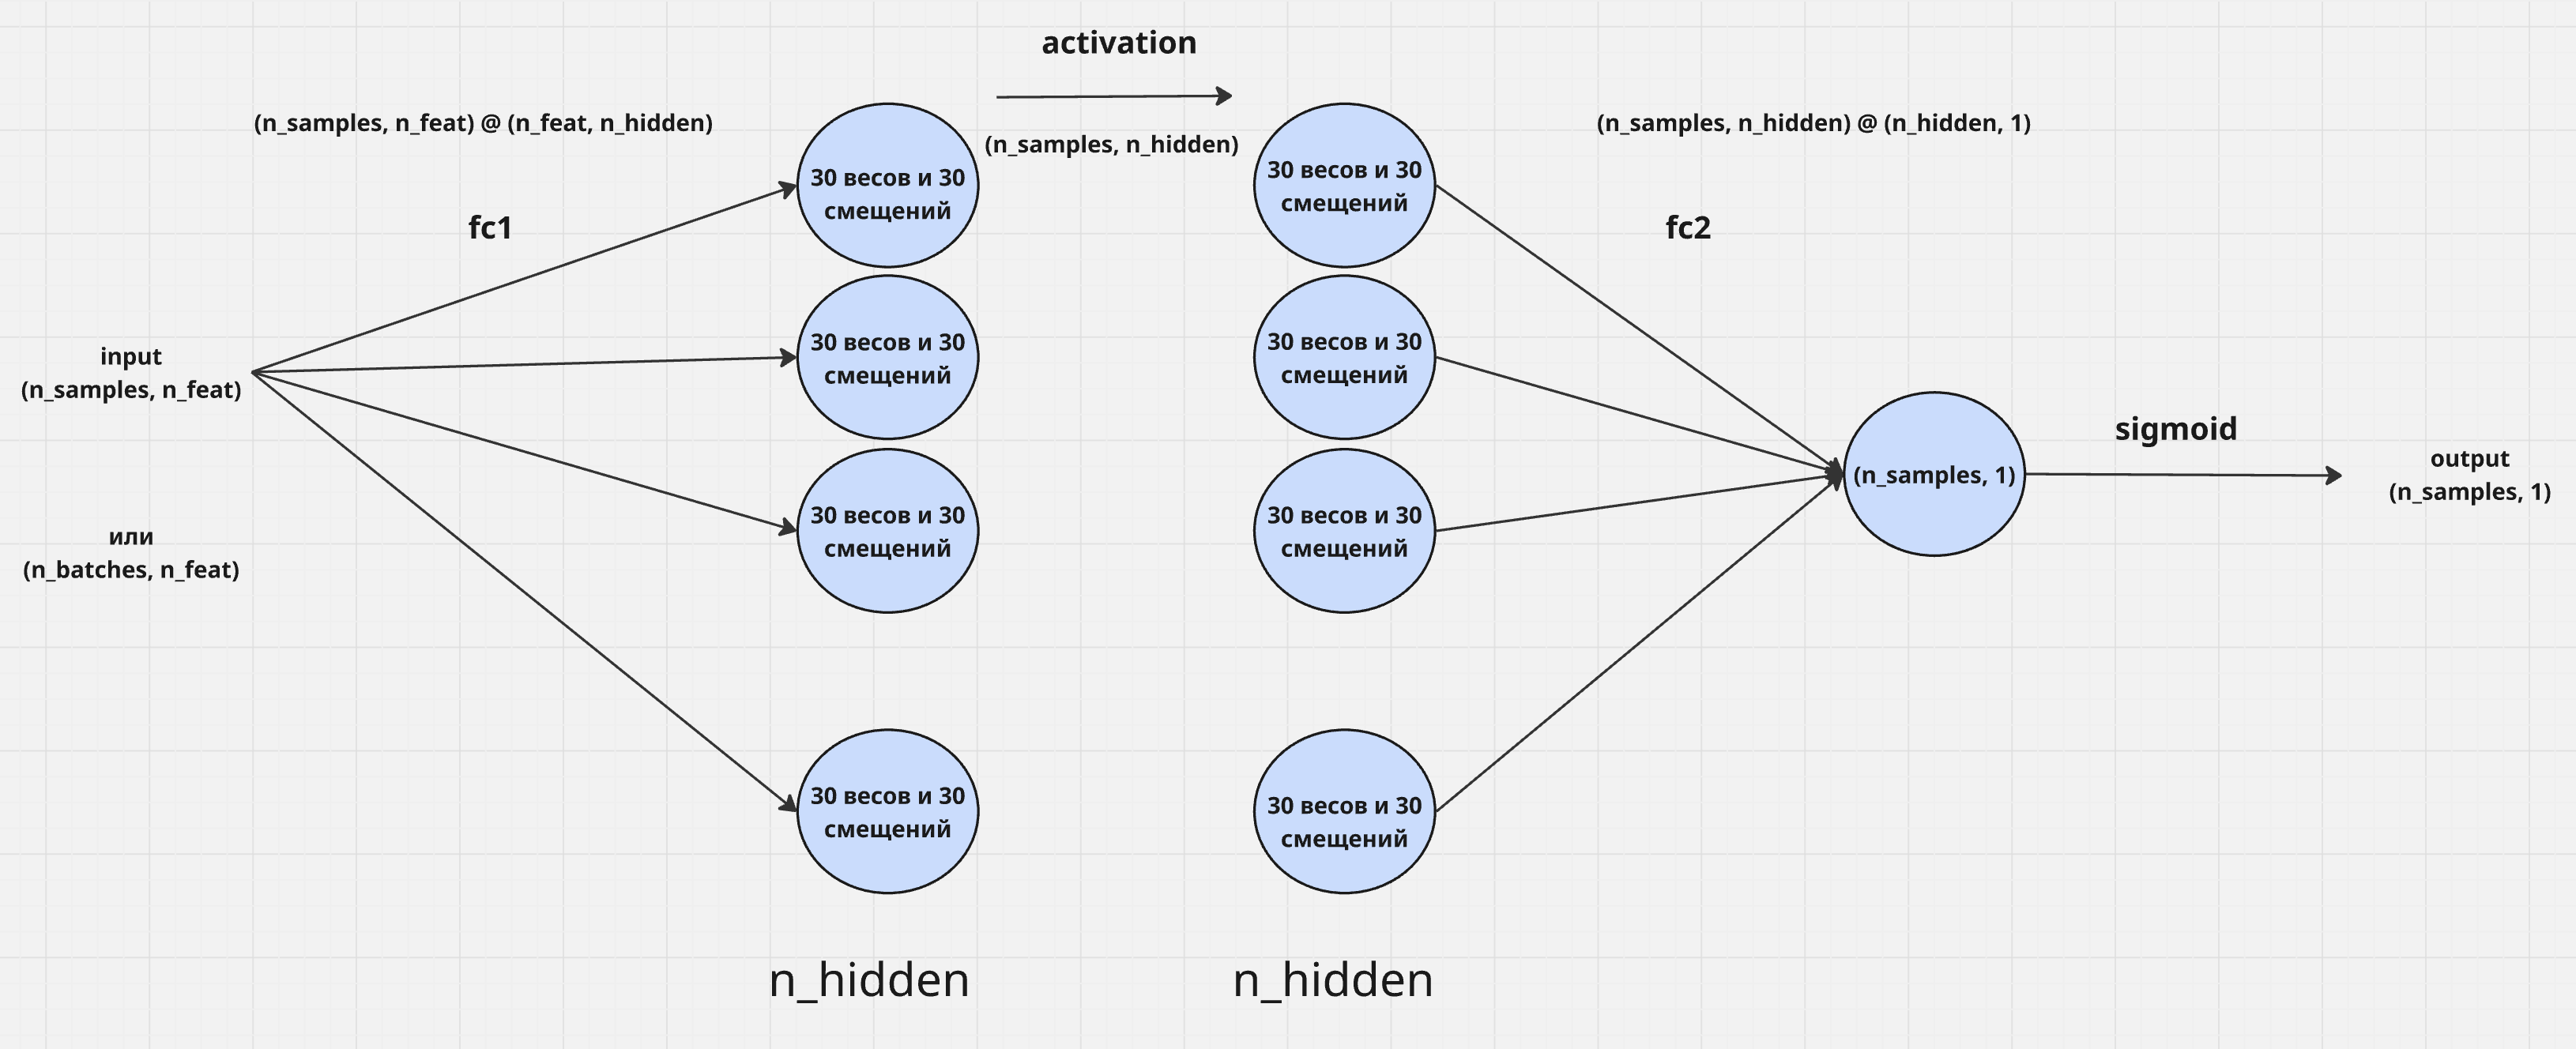

In [16]:
class MyMLP:
  def __init__(self, n_hidden, activation:str, optimizer:str, lr:float, batch_size:int=32, random_state=21):
    self.n_hidden = n_hidden
    self.activation = activation
    self.optimizer = optimizer
    self.batch_size = batch_size
    self.lr = lr
    self.random_state = random_state
    self.initialized = False

  def fit(self, X, Y):
    X = np.asarray(X).astype(np.float32)
    Y = np.asarray(Y).astype(np.int32)
    n_samples, n_feat = X.shape[0], X.shape[1]

    if not self.initialized:
      np.random.seed(self.random_state)
      self._initialize_weights(X.shape[1])

    # batch SGD
    for batch_X, batch_Y in self._batch_generator(X, Y):
          preds = self.forward(batch_X)
          grads = self.backward(batch_X, preds, batch_Y)
          if self.optimizer=="sgd":
            self._update_weights(*grads)
          else: # ADAM
            self._adam(*grads)

    return self

  def predict_proba(self, X):
    X = np.asarray(X).astype(np.float32)
    if not self.initialized:
      raise Exception("Модель не обучена. Сначала вызовите fit().")
    return self.forward(X)

  def predict(self, X):
    X = np.asarray(X).astype(np.float32)
    if not self.initialized:
      raise Exception("Модель не обучена. Сначала вызовите fit().")
    proba = self.forward(X)[:, 0]
    return (proba >= 0.5).astype(int)


  def forward(self, X):
    # fc1 - (n_samples, n_feat) @ (n_feat, h) > (n_samples, h)
    self.fc1_out = X @ self.fc1_weights + self.fc1_bias

    # act
    if self.activation=="relu":
      self.act_out = self._relu(self.fc1_out) # (n_samples, h)
    elif self.activation=="sigmoid":
      self.act_out = self._sigmoid(self.fc1_out)
    elif self.activation=="cosine":
      self.act_out = self._cosine(self.fc1_out)
    elif self.activation=="leaky_relu":
      self.act_out = self._leaky_relu(self.fc1_out)
    else: # tanh
      self.act_out = self._tanh(self.fc1_out)

    # fc2 - (n_samples, h) @ (h, 1) > (n_samples, 1)
    self.fc2_out = self.act_out @ self.fc2_weights + self.fc2_bias
    preds = self._sigmoid(self.fc2_out)
    return preds # (n_samples, 1)


  def backward(self, batch_X, preds, batch_Y_true):
    # grad for loss(BCE)+sigmoid > p - y
    d_loss_d_logits = preds - batch_Y_true.reshape(-1, 1) # (batch, 1)

    # grad for fc2 by activation output
    d_fc2_weights = self.act_out.T @ d_loss_d_logits
    # градиент по байес = сумма байесов по батчам/сэмплам
    d_fc2_bias = d_loss_d_logits.sum(axis=0)
    d_fc2_d_act = d_loss_d_logits @ self.fc2_weights.T

    # grad for relu by fc1 output
    if self.activation=="relu":
      mask_relu = (self.fc1_out > 0).astype(int)
      d_act_d_fc1 = d_fc2_d_act * mask_relu

    elif self.activation == "sigmoid":
      d_act_d_fc1 = d_fc2_d_act * self.act_out * (1 - self.act_out)

    elif self.activation=="cosine":
      d_act_d_fc1 = d_fc2_d_act * (-np.sin(self.fc1_out))

    elif self.activation=="leaky_relu":
      d_act_d_fc1 = d_fc2_d_act * np.where(self.fc1_out > 0, 1, self.alpha)

    else: # tanh d_tanh = (1 - d_tanh**2)
      d_act_d_fc1 = d_fc2_d_act * (1 -  self.act_out**2)

    # grad for fc1 by input layer
    d_fc1_weights = batch_X.T @ d_act_d_fc1
    d_fc1_bias = d_act_d_fc1.sum(axis=0)

    return d_fc1_weights, d_fc1_bias, d_fc2_weights, d_fc2_bias

  def score(self, X, Y):
    X = np.asarray(X).astype(np.float32)
    Y = np.asarray(Y).astype(np.float32)
    preds = self.forward(X)
    loss = self._BCE(Y, preds)
    acc = np.mean((preds[:, 0] >= 0.5) == Y)
    return loss, acc

  def _initialize_weights(self, n_features):
    np.random.seed(self.random_state)
    # fc1: He-init для ReLU, sigmoidа
    scale1 = np.sqrt(2 / n_features) if self.activation == 'relu' else np.sqrt(1 / n_features)
    self.fc1_weights = np.random.normal(0, scale1, (n_features, self.n_hidden))
    self.fc1_bias = np.zeros(self.n_hidden)

    # fc2: Xavier для sigmoid
    scale2 = np.sqrt(1 / self.n_hidden)   #np.sqrt(2/(self.n_hidden+2))
    self.fc2_weights = np.random.normal(0, scale2, (self.n_hidden, 1))
    self.fc2_bias = np.zeros(1)
    self.initialized = True

    if self.optimizer=="adam":
      self.t = 0
      # fc1 & fc2 if adam
      self.m_fc1_w = np.zeros((n_features, self.n_hidden), dtype=float)  #(n_features, self.n_hidden)
      self.v_fc1_w = np.zeros((n_features, self.n_hidden), dtype=float)
      self.m_fc1_b = np.zeros(self.n_hidden)
      self.v_fc1_b = np.zeros(self.n_hidden)

      self.m_fc2_w = np.zeros(((self.n_hidden, 1)), dtype=float)
      self.v_fc2_w = np.zeros(((self.n_hidden, 1)), dtype=float)
      self.m_fc2_b = np.zeros(1)
      self.v_fc2_b = np.zeros(1)



#### Activation Functions
  def _relu(self, input:np.array):
    # input (n_samples, h)
    # np.maximum - поэлементно
    return np.maximum(0, input)

  def _leaky_relu(self, input:np.array):
    self.alpha = 0.01
    return np.maximum(self.alpha*input, input)

  def _sigmoid(self, input:np.array):
    input = np.clip(input, -500, 500)
    return 1 / (1 + np.exp(-input))


  def _softmax(self, input:np.array):
    # input(n_samples, 2)
    e_x = np.exp(input - np.max(input, axis=1, keepdims=True))
    return e_x/np.sum(e_x, axis=1, keepdims=True)
    # (n_samples, n_classes) / (n_samples,) > (n_samples, n_classes) / (n_samples, 1)

  def _cosine(self, input:np.array):
    return np.cos(input)

  def _tanh(self, input:np.array):
    return np.tanh(input)
####


  def _BCE(self, Y_true, preds):
    # X (n_samples, n_feat)
    # Y (n_samples,)
    # preds (n_samples,1)
    epsilon = 1e-15
    preds = np.clip(preds[:,0], epsilon, 1 - epsilon) # log(0) = -inf
    BCE = -np.mean(Y_true * np.log(preds) + (1- Y_true) * np.log (1- preds))
    return BCE


  def _batch_generator(self, X, Y):
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    X_shuffled = X[indices]
    Y_shuffled = Y[indices]

    for start_idx in range(0, n_samples, self.batch_size):
        end_idx = min(start_idx + self.batch_size, n_samples)
        batch_X = X_shuffled[start_idx:end_idx]
        batch_Y = Y_shuffled[start_idx:end_idx]
        yield batch_X, batch_Y

  def _update_weights(self, fc1_wgrad, fc1_bgrad, fc2_wgrad, fc2_bgrad):
    self.fc1_weights -= self.lr * fc1_wgrad
    self.fc1_bias -= self.lr * fc1_bgrad
    self.fc2_weights -= self.lr * fc2_wgrad
    self.fc2_bias -= self.lr * fc2_bgrad

  def _adam(self, fc1_wgrad, fc1_bgrad, fc2_wgrad, fc2_bgrad):
    self.t += 1

    self._update_moments(self.fc1_weights, self.m_fc1_w, self.v_fc1_w, fc1_wgrad, t=self.t)
    self._update_moments(self.fc1_bias, self.m_fc1_b, self.v_fc1_b, fc1_bgrad, t=self.t)

    self._update_moments(self.fc2_weights, self.m_fc2_w, self.v_fc2_w, fc2_wgrad, t=self.t)
    self._update_moments(self.fc2_bias, self.m_fc2_b, self.v_fc2_b, fc2_bgrad, t=self.t)

  def _update_moments(self, param, m, v, param_grad, t):
      beta1 = 0.9
      beta2 = 0.999
      eps = 1e-8

      m[:] = beta1 * m + (1 - beta1) * param_grad #[:] - модификация массива на месте
      v[:] = beta2 * v + (1 - beta2) * (param_grad * param_grad)
      m_corr = m / (1 - beta1 ** t)
      v_corr = v / (1 - beta2 ** t)
      param -= self.lr * m_corr/ (np.sqrt(v_corr) + eps)

- Design a basic train-validation loop: iterate over the training dataset, batch by batch, update the parameters of the network, and check the quality of the model using the validation set.

In [17]:
X_train, X_valid, X_test, Y_train, Y_valid, Y_test = prepare_data_for_MLP()

- Тренируем сначала на SGD; выбираю ReLU, потому что в рекомендациях данную активацию советуют как хороший бейзлайн.

In [18]:
model_sgd = MyMLP(
    n_hidden=32,
    activation="relu",
    optimizer="sgd",
    lr=0.01,
    batch_size=32,
    random_state=21
)

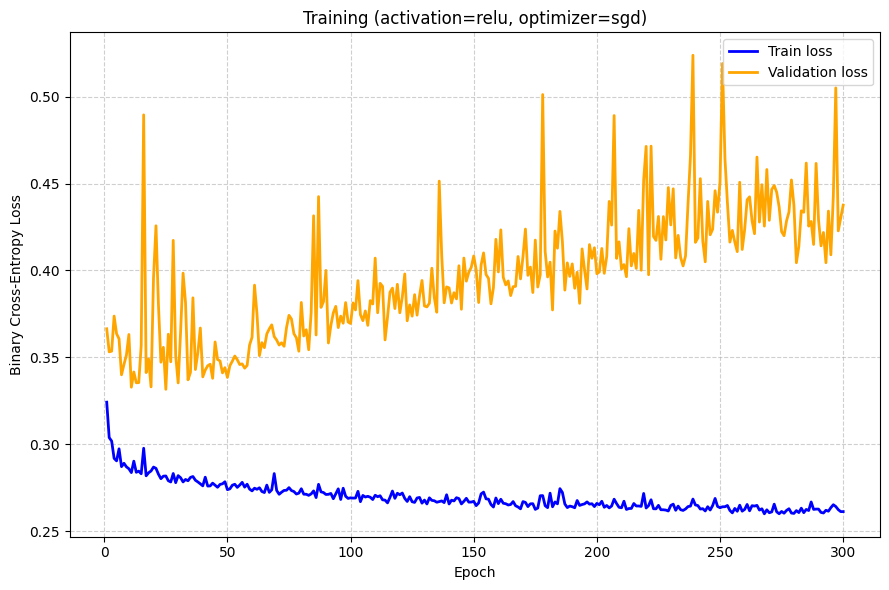

In [19]:
train_plot_loss_log(model_sgd, X_train, Y_train, X_valid, Y_valid, n_epochs=300)

- То же самое, но тренируем на optimizer="adam". Должны лучше сходиться градиенты за счет адаптивной скорости обучения для каждого параметра и накопления направления прошлых градиентов (экспоненциальное скользящее среднее).

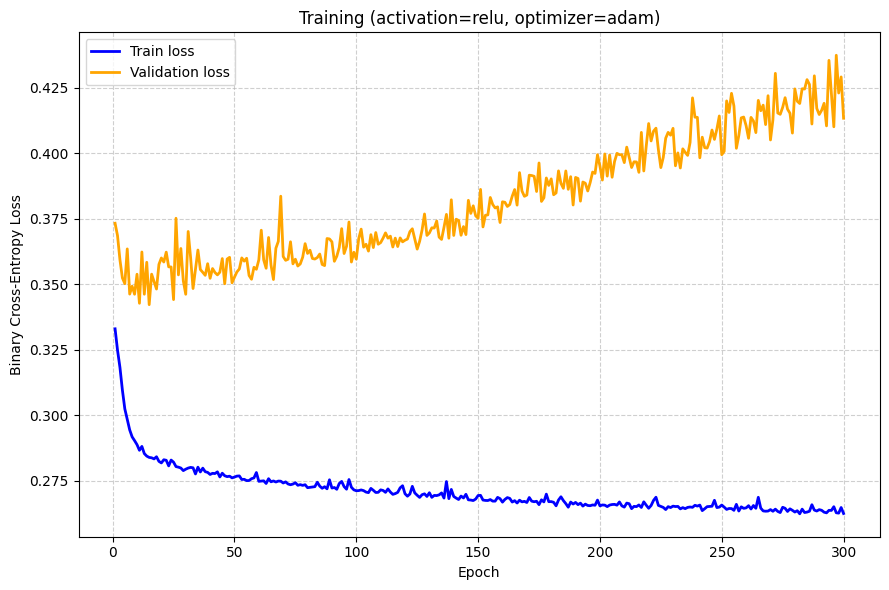

In [20]:
X_train, X_valid, X_test, Y_train, Y_valid, Y_test = prepare_data_for_MLP()
model_adam = MyMLP(
    n_hidden=32,
    activation="relu",
    optimizer="adam",
    lr=0.001,
    batch_size=32,
    random_state=21
)

train_plot_loss_log(model_adam, X_train, Y_train, X_valid, Y_valid, n_epochs=300)

## 3. Train

- With your MLP module and careful network engineering, you must obtain at least a 0.15 Gini score on the validation dataset. You can train for more than 1 epoch, use different activation functions, and different optimizers (like SGD or Adam).

In [21]:
gini_results(model_sgd, X_train, X_valid, X_test, Y_train, Y_valid, Y_test,
             model_descr="My_MLP (SGD + ReLU)")

gini_results(model_adam, X_train, X_valid, X_test, Y_train, Y_valid, Y_test,
             model_descr="My_MLP (ADAM + ReLU)")

In [22]:
my_results_df = pd.DataFrame(gini_results_list)
my_results_df

,model,train_gini,valid_gini,test_gini
0,My_MLP (SGD + ReLU),0.6618,0.3178,0.2306
1,My_MLP (ADAM + ReLU),0.6555,0.3443,0.2758


## 4. Comparison with sklearn MLPClassifier

- Use sklearn's MLPClassifier and check its performance on the validation dataset. Is it better than your module? If so, why?

In [23]:
X_train, X_valid, X_test, Y_train, Y_valid, Y_test = prepare_data_for_MLP()

In [24]:
from sklearn.neural_network import MLPClassifier
# my MLP - 1 скрытый слой (32 нейрона), в конце также сигмоида
sklearn_mlp_sgd = MLPClassifier(hidden_layer_sizes=(32,),
                                activation="relu",
                                solver="sgd",
                                batch_size=32,
                                learning_rate_init=0.1,
                                random_state=21,
                                max_iter=300)
sklearn_mlp_sgd.fit(X_train, Y_train)

MLPClassifier(batch_size=32, hidden_layer_sizes=(32,), learning_rate_init=0.1,
              max_iter=300, random_state=21, solver='sgd')

In [25]:
X_train, X_valid, X_test, Y_train, Y_valid, Y_test = prepare_data_for_MLP()
sklearn_mlp_adam = MLPClassifier(hidden_layer_sizes=(32,),
                                activation="relu",
                                solver="adam",
                                batch_size=32,
                                learning_rate_init=0.001,
                                random_state=21,
                                max_iter=300,
                                beta_1=0.9,
                                beta_2 = 0.999,
                                epsilon=1e-8)
sklearn_mlp_adam.fit(X_train, Y_train)

MLPClassifier(batch_size=32, hidden_layer_sizes=(32,), max_iter=300,
              random_state=21)

In [26]:
gini_results(sklearn_mlp_sgd, X_train, X_valid, X_test, Y_train, Y_valid, Y_test,
             model_descr="Sk_MLP (SGD + ReLU)")

gini_results(sklearn_mlp_adam, X_train, X_valid, X_test, Y_train, Y_valid, Y_test,
             model_descr="Sk_MLP (ADAM + ReLU)")

In [27]:
results_df = pd.DataFrame(gini_results_list)
results_df

,model,train_gini,valid_gini,test_gini
0,My_MLP (SGD + ReLU),0.6618,0.3178,0.2306
1,My_MLP (ADAM + ReLU),0.6555,0.3443,0.2758
2,Sk_MLP (SGD + ReLU),0.6298,0.3463,0.2703
3,Sk_MLP (ADAM + ReLU),0.6379,0.3816,0.3046


### Моя реализация:
- ADAM лучше, чем SGD на валидационных и тестовых частях данных;
- на валидационных данных лучший gini 0.34, на тесте 0.28 (ReLU+ADAM в обоих случаях);
- меньше выражено переобучения в случае ADAM.


### Sklearn MLP:
- ADAM лучше на всех частях данных;
- тоже меньше выражено переобучение в случае ADAM;
- на валидационных данных лучший gini 0.38 (SGD), на тесте 0.30 (ADAM).

- возможно, если запускать не с теми же параметрами, что и мою модель, и/или оптимизировать гиперпараметры, то метрики будут лучше, но сравнение лоб в лоб вот такое.

## 5. Implement and try different activation functions: sigmoid, ReLU, cosine.

- Remember that you have to derive gradients for each different activation function. Which activation function gives the best performance on the validation dataset?

- Реализации различных функций активации см. внутри класса;
- Везде будем использовать optimizer="ADAM", потому что он лучше показал себя в пред. задании.

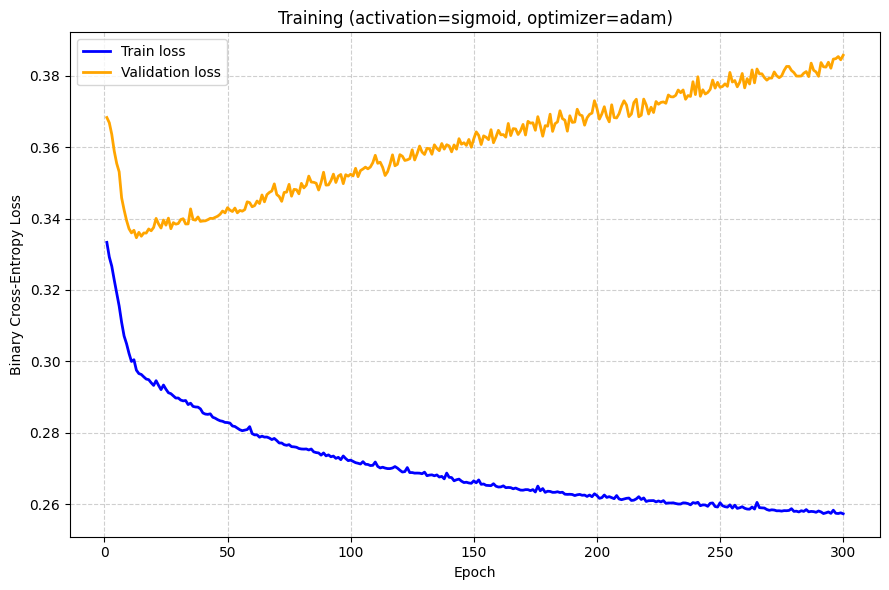

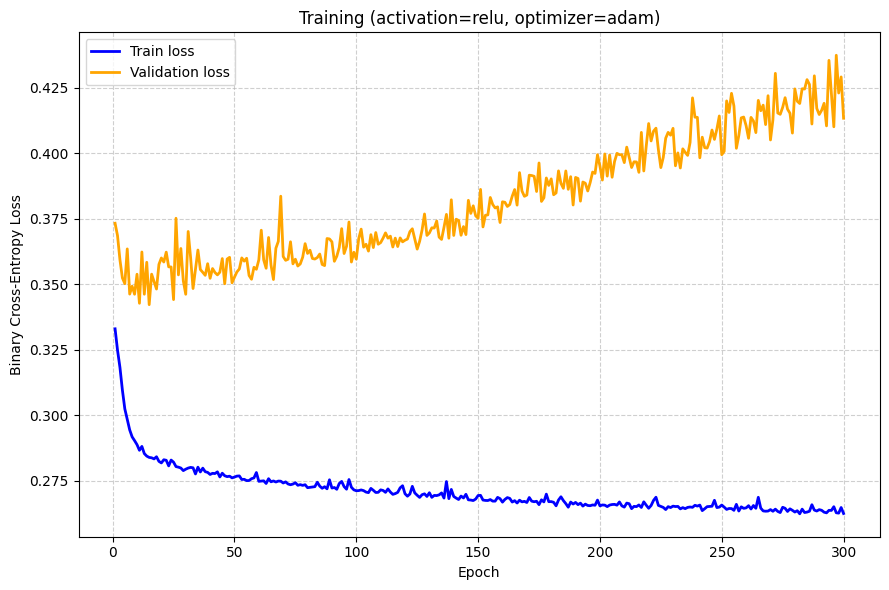

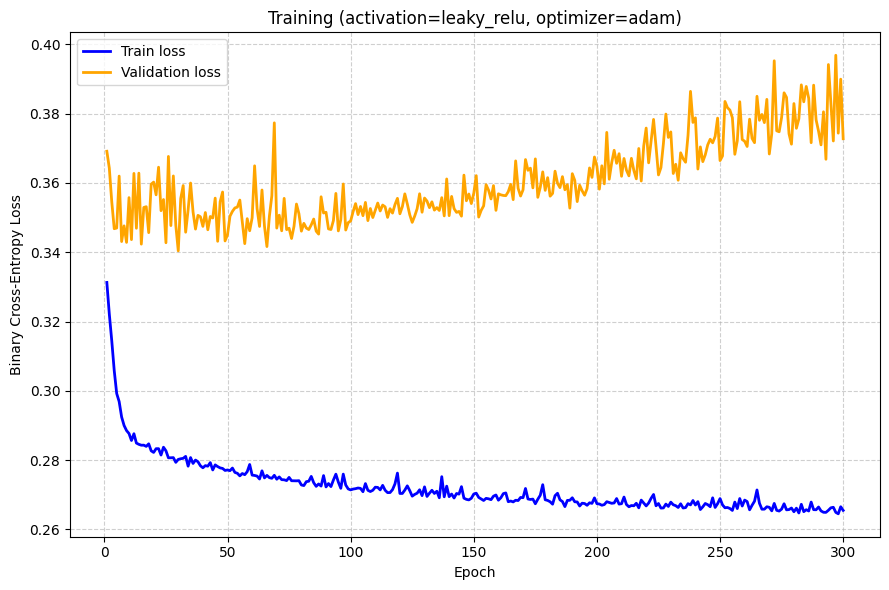

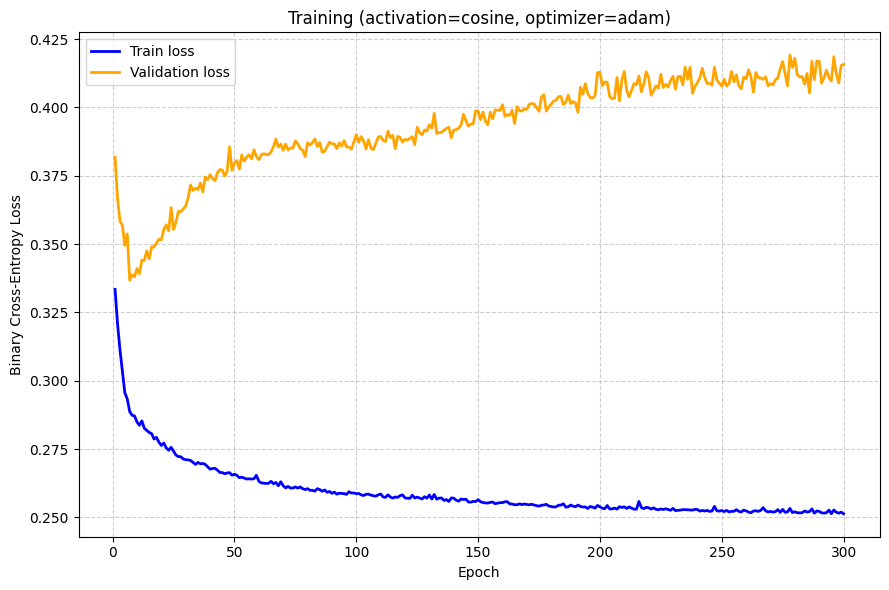

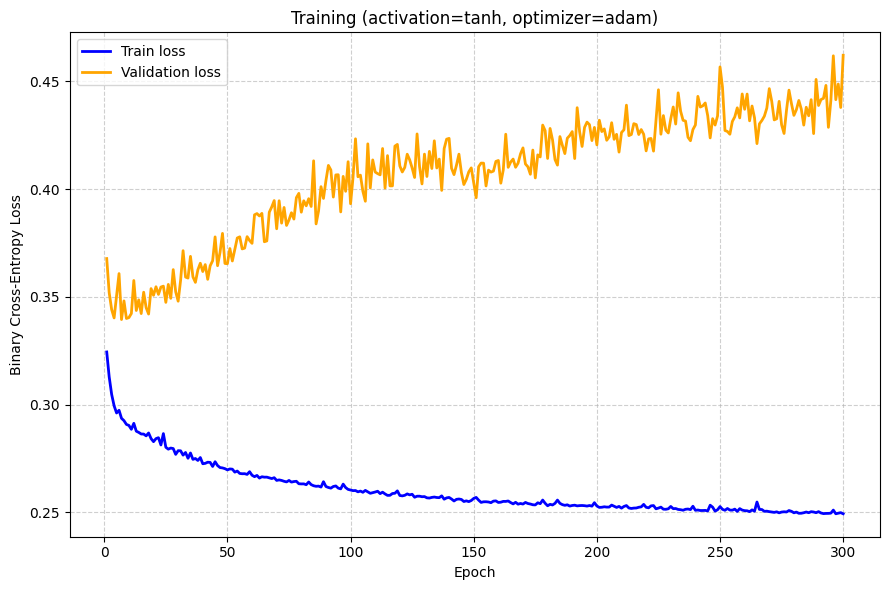

In [28]:
activations_list = ["sigmoid", "relu", "leaky_relu", "cosine", "tanh"]

for act in activations_list:
  X_train, X_valid, X_test, Y_train, Y_valid, Y_test = prepare_data_for_MLP()
  model = MyMLP(n_hidden=32,
                activation=act,
                optimizer="adam",
                lr=0.001,
                batch_size=32,
                random_state=21)
  train_plot_loss_log(model, X_train, Y_train, X_valid, Y_valid, n_epochs=300)
  gini_results(model, X_train, X_valid, X_test, Y_train, Y_valid, Y_test,
             model_descr=f"My_MLP (ADAM + {act})")

In [29]:
results_df = pd.DataFrame(gini_results_list)
results_df

,model,train_gini,valid_gini,test_gini
0,My_MLP (SGD + ReLU),0.6618,0.3178,0.2306
1,My_MLP (ADAM + ReLU),0.6555,0.3443,0.2758
2,Sk_MLP (SGD + ReLU),0.6298,0.3463,0.2703
3,Sk_MLP (ADAM + ReLU),0.6379,0.3816,0.3046
4,My_MLP (ADAM + sigmoid),0.6742,0.3555,0.2078
5,My_MLP (ADAM + relu),0.6555,0.3443,0.2758
6,My_MLP (ADAM + leaky_relu),0.6449,0.4008,0.3709
7,My_MLP (ADAM + cosine),0.6900,0.3894,0.2098
8,My_MLP (ADAM + tanh),0.7015,0.3016,0.1618


- На основе значений коэффициента gini получено следующее ранжирование активационных функций (по убыванию качества):
 Leaky ReLU > ReLU > cosine > sigmoid > tanh.

- Данный порядок согласуется с общепринятыми рекомендациями для полносвязных архитектур:

- **Leaky ReLU** продемонстрировала наилучший результат на тесте, по-видимому, за счет того, что обеспечивает более центрированный выход за счёт ненулевого наклона в отрицательной области по сравнению с классической ReLU.

- **ReLU** продемонстрировала средний результат благодаря отсутствию насыщения градиента в области положительных значений, вычислительной простоте (отсутствие экспонент) и умеренной вычислительной нагрузке. Недостатки ReLU (ненулевое среднее выхода, зануление градиентов при отрицательных входах) в данной задаче не привели к существенному ухудшению сходимости.

- **ELU** (не реализована в работе) теоретически позволяет устранить затухание градиентов при отрицательных значениях благодаря экспоненциальной аппроксимации; её применение могло бы дать дополнительный прирост качества.

- **tanh** и **sigmoid** показали наихудшие результаты. Это объясняется эффектом насыщения на краях области значений, что приводит к исчезновению градиентов, а также высокой вычислительной стоимостью из-за многократного вычисления экспонент. В связи с этим их использование в скрытых слоях полносвязных сетей считается нецелесообразным. Тем не менее данные функции остаются востребованными в рекуррентных архитектурах (RNN, LSTM) и на выходных слоях задач бинарной классификации, где требуется отображение в ограниченный интервал.

 - Косинусная активация **cosine** была рассмотрена в экспериментальном порядке; несмотря на более высокий результат по сравнению с сигмоидальными функциями, её применение в скрытых слоях не является стандартным  (но в задании очень хотели, чтобы мы ее реализовали).

- Таким образом, в условиях данной задачи оптимальный выбор — использование Leaky ReLu/ReLU в скрытых слоях и сигмоиды на выходном слое (согласно условию задания).

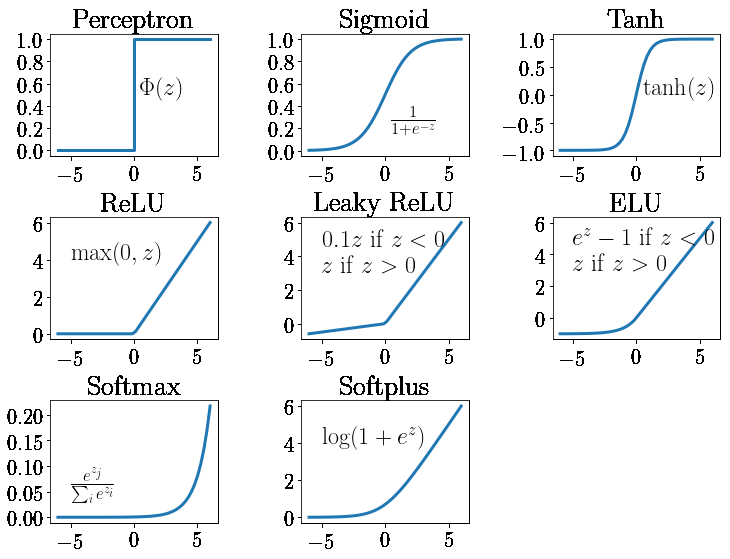

## 6. Design an MLP module with 1 hidden layer

- using any high level deep learning framework: Pytorch, Keras, or Tensorflow. Check its performance on the validation dataset.  Is it better than your module? If so, why?

In [30]:
import torch
import torch.nn as nn
from tqdm import tqdm

class MLP(nn.Module):
  def __init__(self, n_hidden, n_features):
    super(MLP, self).__init__()

    self.fc1 = nn.Linear(n_features, n_hidden)
    self.act1 = nn.ReLU()

    self.fc2 = nn.Linear(n_hidden, 1)
    self.act2 = nn.Sigmoid()

  def forward(self, X):

    X = self.fc1(X)
    X = self.act1(X)

    X = self.fc2(X)
    X = self.act2(X)
    return X

In [31]:
def train_mlp(model, X, Y, criterion, optimizer, num_epoch):
  for t in tqdm(range(num_epoch)):
    y_pred = model(X)
    loss = criterion(y_pred, Y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  return model

### helper functions (torch)

In [32]:
def transform_to_tensor(X, dtype=torch.float32):
  if isinstance(X, (pd.Series, pd.DataFrame)):
    X_np = X.values
  else:
    X_np = np.asarray(X)
  return torch.as_tensor(X_np, dtype=dtype)

def prepare_tensors(X, Y):
  X_tensor = transform_to_tensor(X, dtype=torch.float32)
  Y_tensor = transform_to_tensor(Y, dtype=torch.float32)
  if Y_tensor.dim() == 1:
        Y_tensor = Y_tensor.view(-1, 1)
  return X_tensor, Y_tensor

def eval_model(model, X):
    model.eval()
    with torch.no_grad():
        probas = model(X) # (batch, 1)
        probas_np = probas.numpy()
        probas_class1 = probas_np[:, 0] # (batch,) — вероятности класса 1
    return probas_class1, probas_np

In [33]:
def gini_results_torch(train_pred, valid_pred, test_pred, Y_train, Y_valid, Y_test, model_descr:str):
  train_gini = calc_gini(Y_train, train_pred)
  valid_gini = calc_gini(Y_valid, valid_pred)
  test_gini = calc_gini(Y_test, test_pred)

  gini_results_list.append({
    'model': model_descr,
    'train_gini': f"{train_gini:.4f}",
    'valid_gini': f"{valid_gini:.4f}",
    'test_gini': f"{test_gini:.4f}"
})

### Train PyTorch MLP

In [34]:
model = MLP(n_hidden=32, n_features=X_train.shape[1])
criterion = torch.nn.BCELoss()
optimizer =  torch.optim.Adam(model.parameters(), lr=1e-3)


X_train, X_valid, X_test, Y_train, Y_valid, Y_test = prepare_data_for_MLP()
X_train, Y_train = prepare_tensors(X_train, Y_train)
X_valid, Y_valid = prepare_tensors(X_valid, Y_valid)
X_test, Y_test  = prepare_tensors(X_test,  Y_test)

model = train_mlp(model, X_train, Y_train, criterion, optimizer, 300)

proba_class1_train, proba_both_train = eval_model(model, X_train)
proba_class1_valid, proba_both_valid = eval_model(model, X_valid)
proba_class1_test, proba_both_test = eval_model(model, X_test)

100%|██████████| 300/300 [00:02<00:00, 115.37it/s]


In [35]:
gini_results_torch(proba_class1_train, proba_class1_valid, proba_class1_test, Y_train, Y_valid, Y_test,
                   model_descr="PyTorch_MLP")

In [36]:
results_df = pd.DataFrame(gini_results_list)
results_df

,model,train_gini,valid_gini,test_gini
0,My_MLP (SGD + ReLU),0.6618,0.3178,0.2306
1,My_MLP (ADAM + ReLU),0.6555,0.3443,0.2758
2,Sk_MLP (SGD + ReLU),0.6298,0.3463,0.2703
3,Sk_MLP (ADAM + ReLU),0.6379,0.3816,0.3046
4,My_MLP (ADAM + sigmoid),0.6742,0.3555,0.2078
5,My_MLP (ADAM + relu),0.6555,0.3443,0.2758
6,My_MLP (ADAM + leaky_relu),0.6449,0.4008,0.3709
7,My_MLP (ADAM + cosine),0.6900,0.3894,0.2098
8,My_MLP (ADAM + tanh),0.7015,0.3016,0.1618
9,PyTorch_MLP,0.3847,0.3145,0.3202


- Подробно результаты обсуждены выше; в целом в условиях данной задачи оптимальный выбор — использование Leaky ReLu/ReLU в скрытых слоях и сигмоиды на выходном слое (согласно условию задания).

## 7. Choose the best model

- Take the best model and estimate its performance on the test dataset: check the Gini scores on all three datasets for your best model: training Gini, valid Gini, test Gini.
- Do you see a drop in performance when comparing the valid quality to the test quality? Is your model overfitting or not? Explain.

In [37]:
results_df

,model,train_gini,valid_gini,test_gini
0,My_MLP (SGD + ReLU),0.6618,0.3178,0.2306
1,My_MLP (ADAM + ReLU),0.6555,0.3443,0.2758
2,Sk_MLP (SGD + ReLU),0.6298,0.3463,0.2703
3,Sk_MLP (ADAM + ReLU),0.6379,0.3816,0.3046
4,My_MLP (ADAM + sigmoid),0.6742,0.3555,0.2078
5,My_MLP (ADAM + relu),0.6555,0.3443,0.2758
6,My_MLP (ADAM + leaky_relu),0.6449,0.4008,0.3709
7,My_MLP (ADAM + cosine),0.6900,0.3894,0.2098
8,My_MLP (ADAM + tanh),0.7015,0.3016,0.1618
9,PyTorch_MLP,0.3847,0.3145,0.3202


- Сочетание Leaky ReLu + ADAM практически не дает переобучения (метрики для валидационых и тестовых данных близки)
- Завышение метрики на тренировочных данных - нормальное явление, тк модель уже видела эти данные при обучении.